In [ ]:
using Pkg

Pkg.activate(".")
Pkg.instantiate()

# Pkg.add("Revise")
# using Revise

versioninfo()

In [2]:
Pkg.add("DataFrames")
Pkg.add("CSV")

   Updating registry at `C:\Users\fabianmoss\.julia\registries\General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %

  Resolving package versions...
No Changes to `C:\Users\fabianmoss\Desktop\HistoryModes_DataCode\Project.toml`
No Changes to `C:\Users\fabianmoss\Desktop\HistoryModes_DataCode\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\fabianmoss\Desktop\HistoryModes_DataCode\Project.toml`
No Changes to `C:\Users\fabianmoss\Desktop\HistoryModes_DataCode\Manifest.toml`


In [3]:
Pkg.add("StatsFuns")
Pkg.add("SpecialFunctions")
Pkg.add("LogProbs")
Pkg.add("Gadfly")
Pkg.add("Random")
Pkg.add("ProgressMeter")
Pkg.add("DataStructures")
Pkg.add("LightQuery")

include("CompoundDistributions.jl")
using .CompoundDistributions
using LogProbs
using DataFrames
using Gadfly
using Random
using CSV
using ProgressMeter

  Resolving package versions...
No Changes to `C:\Users\fabianmoss\Desktop\HistoryModes_DataCode\Project.toml`
No Changes to `C:\Users\fabianmoss\Desktop\HistoryModes_DataCode\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\fabianmoss\Desktop\HistoryModes_DataCode\Project.toml`
No Changes to `C:\Users\fabianmoss\Desktop\HistoryModes_DataCode\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\fabianmoss\Desktop\HistoryModes_DataCode\Project.toml`
No Changes to `C:\Users\fabianmoss\Desktop\HistoryModes_DataCode\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\fabianmoss\Desktop\HistoryModes_DataCode\Project.toml`
No Changes to `C:\Users\fabianmoss\Desktop\HistoryModes_DataCode\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\fabianmoss\Desktop\HistoryModes_DataCode\Project.toml`
No Changes to `C:\Users\fabianmoss\Desktop\HistoryModes_DataCode\Manifest.toml`
  Resolving package versions...
No Changes to

In [4]:
using LightQuery: @>
using SpecialFunctions: logbeta # lbeta
using Statistics: mean
using DataStructures: counter
using LinearAlgebra: normalize

# Read the data

In [6]:
data = CSV.read("pitch_class_distributions.csv")
first(data, 6)

,year,root,mode,pc0,pc1,pc2,pc3,pc4
,Float64,Float64?,String?,Float64,Float64,Float64,Float64,Float64
1,1556.0,missing,missing,0.0629291,0.0,0.268307,0.0,0.0549199
2,1556.0,missing,missing,0.0820863,0.0,0.24846,0.000880282,0.0607394
3,1556.0,missing,missing,0.102664,0.0,0.237204,0.00868004,0.0580664
4,1556.0,missing,missing,0.0880412,0.0,0.24268,0.0,0.0847423
5,1556.0,missing,missing,0.0889396,0.0,0.269099,0.0,0.0661345
6,1556.0,missing,missing,0.0829876,0.0,0.245851,0.00311203,0.0715768


In [7]:
pcs = [Symbol("pc", i) for i in 0:11]
periods = collect(0:4)
period_starts = vcat(0, parse.(Int, readlines("start_years.txt")), 2001)
period_ranges = [period_starts[p]:(period_starts[p+1]-1) for p in 1:5]

5-element Array{UnitRange{Int64},1}:
 0:1649
 1650:1758
 1759:1817
 1818:1856
 1857:2000

In [8]:
function timeperiod(year)
    for (p, pr) in zip(periods, period_ranges) 
        if first(pr) <= year <= last(pr)
            return p
        end
    end
    println(year)
    @assert true "not a year between 0 and 2000"
end

data.period = map(timeperiod, data.year)

# pcwd ... pitch-class distribution, weighted by durations
pcwds_by_period = [Matrix(data[data.period .== p, pcs]) for p in periods]
mode_labels_by_period = [data[data.period .== p, :mode] for p in periods]

pieces_per_period = counter(data.period)

println("Number of pieces: $(size(data, 1))")
println()
println("Pieces per period:")
println.(sort(collect(pieces_per_period), by=first));

Number of pieces: 13402

Pieces per period:
0 => 1180
1 => 3481
2 => 3311
3 => 2000
4 => 3430


# Implement Bayesian model

In [9]:
# number of pitch classes per piece
const N = 10000

function bayesian_model(pcwds_by_period, k=2, steps=10)
    gibbs_sampling!(pcwds_by_period, init_model(modes=1:k), steps)
end

function init_model(;periods=0:4, modes=0:1, roots=0:11)
    period_dist = DirCat(Dict(t=>1 for t in periods))
    root_dist = SimpleCond(
        Dict(
            t => DirCat(Dict(r=>1 for r in roots)) 
            for t in periods
        )
    )
    mode_dist = SimpleCond(
        Dict(
            t => DirCat(Dict(m=>1 for m in modes)) 
            for t in periods
        )
    )
    pc_dist = SimpleCond(
        Dict(
            (t,m) => DirMul(Dict(pc=>1 for pc in 0:11)) 
            for t in periods
            for m in modes
        )
    )
    dists = (period_dist, root_dist, mode_dist, pc_dist)
end

function gibbs_sampling!(pcwds_by_period, dists, steps=10)
    samples = random_gibbs_sampling_init!(pcwds_by_period, dists...)
    chain   = Vector{Vector{Tuple{Int,Int}}}[]
    @showprogress 1 "Gibbs sampling..." for i in 1:steps
        old_samples = samples
        samples = gibbs_sampling_step!(pcwds_by_period, dists..., samples)
        push!(chain, samples)
    end
    chain
end

@inline rows(Matrix) = [Matrix[k,:] for k in 1:size(Matrix, 1)]
@inline row_dicts(Matrix) = [
    Dict(k-1 => v for (k,v) in enumerate(r)) 
    for r in rows(Matrix)
]

function random_gibbs_sampling_init!(pcwds_by_period, period_dist, root_dist, mode_dist, pc_dist)
    map(0:length(pcwds_by_period)-1, pcwds_by_period) do p, pcwds
        map(row_dicts(round.(pcwds*N))) do piece
            root = rand(collect(keys(root_dist.dists[p].counts)))
            mode = rand(collect(keys(mode_dist.dists[p].counts)))
            add_obs!(period_dist, p)
            add_obs!(root_dist, root, p)
            add_obs!(mode_dist, mode, p)
            add_obs!(pc_dist.dists[p, mode], piece, root)
            root, mode
        end
    end
end

function gibbs_sampling_step!(pcwds_by_period, period_dist, root_dist, mode_dist, pc_dist, samples_by_period)
    dists = (period_dist, root_dist, mode_dist, pc_dist)
    map(0:length(pcwds_by_period)-1, pcwds_by_period, samples_by_period) do p, pcwds, samples
        map(row_dicts(round.(pcwds*N)), samples) do piece, sample
            old_root, old_mode = sample
            rm_obs!(period_dist, p)
            rm_obs!(root_dist, old_root, p)
            rm_obs!(mode_dist, old_mode, p)
            rm_obs!(pc_dist.dists[p, old_mode], piece, old_root)
            
            root, mode = categorical_sample(joint_dist(piece, p, dists...))
            add_obs!(period_dist, p)
            add_obs!(root_dist, root, p)
            add_obs!(mode_dist, mode, p)
            add_obs!(pc_dist.dists[p, mode], piece, root)
            root, mode
        end
    end
end
    
function joint_prob(root, mode, piece, tp, period_dist, root_dist, mode_dist, pc_dist)
    logscore(period_dist, tp) * 
    logscore(root_dist, root, tp) * 
    logscore(mode_dist, mode, tp) * 
    logscore(pc_dist.dists[tp, mode], piece, root)
end

function joint_dist(piece, tp, period_dist, root_dist, mode_dist, pc_dist)
    dists = (period_dist, root_dist, mode_dist, pc_dist)
    Dict(
        (root, mode) => joint_prob(root, mode, piece, tp, dists...)
        for root in keys(root_dist.dists[tp].counts)
        for mode in keys(mode_dist.dists[tp].counts)
    )
end

function CompoundDistributions.add_obs!(pc_dist::DirMul, pcs, root)
    for pc in keys(pcs)
        pc_dist.counts[mod(pc + root, 12)] += pcs[pc]
    end
end

function CompoundDistributions.rm_obs!(pc_dist::DirMul, pcs, root)
    for pc in keys(pcs)
        pc_dist.counts[mod(pc + root, 12)] -= pcs[pc]
    end
end

function CompoundDistributions.logscore(pc_dist::DirMul, pcs, root)
    n = sum(values(pcs))
    LogProb(
        log(n) + logbeta(sum(values(pc_dist.counts)), n) -
        sum(
            log(pcs[pc]) + logbeta(pc_dist.counts[mod(pc + root, 12)], pcs[pc])
            for pc in keys(pcs) if pcs[pc] > 0
        ), 
        islog=true
    )
end

# Key and mode prediction

In [10]:
Random.seed!(4242)

chain = bayesian_model(pcwds_by_period, 2, 1000)[11:end];

Gibbs sampling...100%|██████████████████████████████████| Time: 0:16:00mmm


In [11]:
key_predictions = map(periods) do period
    n = pieces_per_period[period]
    map(1:n) do piece
        first(maximum(counter(chain[i][period+1][piece] for i in eachindex(chain))))
    end
end

5-element Array{Array{Tuple{Int64,Int64},1},1}:
 [(7, 2), (7, 2), (7, 2), (7, 2), (7, 2), (7, 2), (7, 2), (7, 2), (7, 2), (7, 2)  …  (7, 2), (7, 2), (11, 1), (11, 1), (7, 2), (4, 2), (0, 2), (7, 2), (11, 1), (4, 1)]
 [(5, 1), (3, 2), (5, 1), (3, 2), (8, 2), (8, 2), (5, 2), (10, 2), (5, 1), (8, 2)  …  (5, 1), (3, 1), (10, 2), (8, 2), (1, 1), (3, 2), (3, 1), (3, 1), (3, 2), (3, 2)]
 [(6, 2), (5, 1), (5, 2), (5, 2), (3, 1), (3, 2), (1, 2), (6, 2), (1, 2), (5, 2)  …  (1, 2), (3, 2), (0, 2), (7, 2), (0, 2), (11, 2), (11, 2), (5, 2), (0, 2), (5, 2)]
 [(5, 2), (9, 1), (11, 1), (9, 1), (7, 2), (5, 2), (9, 1), (0, 2), (9, 2), (9, 1)  …  (10, 2), (2, 2), (2, 2), (7, 1), (4, 2), (5, 2), (10, 2), (9, 2), (7, 1), (7, 1)]
 [(0, 2), (3, 1), (5, 1), (9, 2), (6, 2), (5, 1), (2, 1), (0, 1), (7, 1), (5, 2)  …  (4, 1), (3, 2), (4, 1), (2, 1), (11, 1), (1, 2), (4, 1), (4, 1), (0, 2), (5, 1)]

In [12]:
function find_root(pretemplate)
    pc1, pc2 = sort(collect(enumerate(pretemplate)), by=x->x[2], rev=true)[1:2] .|> first .|> x->x-1
    
    if     pc1 + 7 == pc2 || pc1 - 5 == pc2
        pc1
    elseif pc1 + 5 == pc2 || pc1 - 7 == pc2
        pc2
    else
        error("root and fifth are not the two most common notes")
    end
end

function root_position(pretemplate)
    root = find_root(pretemplate)
    circshift(pretemplate, -root)
end

root_position (generic function with 1 method)

In [13]:
pretemplates = map(1:5) do period
    pretemplates = [zeros(12), zeros(12)]
    for ((root, mode), pcwd) in zip(key_predictions[period], rows(pcwds_by_period[period]))
        pretemplates[mode] += circshift(pcwd, root)
    end
    # root_position.(pretemplates)
    pretemplates
end

template_roots = [find_root.(pretemplates[p]) for p in 1:5]

5-element Array{Array{Int64,1},1}:
 [11, 2]
 [0, 3]
 [10, 3]
 [4, 7]
 [7, 0]

In [14]:
templates = map(1:5) do period
    normalize.(root_position.(pretemplates[period]), 1)
end

5-element Array{Array{Array{Float64,1},1},1}:
 [[0.18381673155802752, 0.001151221087376137, 0.15279216508452692, 0.0014718740724856349, 0.11407114847836265, 0.11753501673641525, 0.004047355395241231, 0.18640312970496178, 0.000604604649400258, 0.13396650871958085, 0.003823980143360975, 0.10031626437026084], [0.1998590458035844, 0.002100704711472955, 0.12692929787196577, 0.1244189355701103, 0.015688649407409005, 0.1100364381572903, 0.0051192146461177404, 0.20440718570754463, 0.031532548258347816, 0.04547722136054873, 0.11230682046368139, 0.022123938041927076]]
 [[0.18382273782253447, 0.013070105415917781, 0.11422076535082827, 0.12041336836057198, 0.020361430837805658, 0.11651911746259826, 0.016311746996166887, 0.18054802040860887, 0.07069043325132525, 0.03460329283171003, 0.08498167629684149, 0.04445730496509126], [0.19353280462983263, 0.00660868481376155, 0.13496174519694587, 0.0059816144899526216, 0.1339922774107098, 0.08536833885880415, 0.02578217780269167, 0.19164807563131694, 0.0096

In [15]:
function ismajor(template)
    template[4] < template[5]
end

mode(template) = ismajor(template) ? "major" : "minor"

modeindex(period, modestring) = mode(templates[period][1]) == modestring ? 1 : 2

function plot_template(template)
    plot(x = 0:11, y = template, 
        Geom.bar, 
        Scale.x_discrete,
        Coord.cartesian(ymin=0, ymax=0.25),
        Theme(bar_highlight=color(colorant"black"), default_color=color(colorant"grey")),
        Guide.xlabel("pitch class"),
        Guide.ylabel("probability") )
end

plot_template (generic function with 1 method)

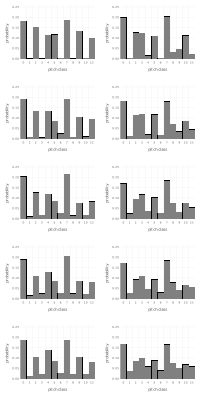

In [16]:
set_default_plot_size(20cm, 40cm)
gridstack([plot_template(templates[p][modeindex(p,m)]) for p in 1:5, m in ["major", "minor"]])

In [17]:
calibrated_key_predictions = map(1:5) do period
    map(key_predictions[period]) do (root, mode)
        (mod(template_roots[period][mode] - root, 12), mode)
    end
end

5-element Array{Array{Tuple{Int64,Int64},1},1}:
 [(7, 2), (7, 2), (7, 2), (7, 2), (7, 2), (7, 2), (7, 2), (7, 2), (7, 2), (7, 2)  …  (7, 2), (7, 2), (0, 1), (0, 1), (7, 2), (10, 2), (2, 2), (7, 2), (0, 1), (7, 1)]
 [(7, 1), (0, 2), (7, 1), (0, 2), (7, 2), (7, 2), (10, 2), (5, 2), (7, 1), (7, 2)  …  (7, 1), (9, 1), (5, 2), (7, 2), (11, 1), (0, 2), (9, 1), (9, 1), (0, 2), (0, 2)]
 [(9, 2), (5, 1), (10, 2), (10, 2), (7, 1), (0, 2), (2, 2), (9, 2), (2, 2), (10, 2)  …  (2, 2), (0, 2), (3, 2), (8, 2), (3, 2), (4, 2), (4, 2), (10, 2), (3, 2), (10, 2)]
 [(2, 2), (7, 1), (5, 1), (7, 1), (0, 2), (2, 2), (7, 1), (7, 2), (10, 2), (7, 1)  …  (9, 2), (5, 2), (5, 2), (9, 1), (3, 2), (2, 2), (9, 2), (10, 2), (9, 1), (9, 1)]
 [(0, 2), (4, 1), (2, 1), (3, 2), (6, 2), (2, 1), (5, 1), (7, 1), (0, 1), (7, 2)  …  (3, 1), (9, 2), (3, 1), (5, 1), (8, 1), (11, 2), (3, 1), (3, 1), (0, 2), (2, 1)]

In [18]:
prediction_df = DataFrame(
    period = vcat([fill(p, pieces_per_period[p]) for p in 0:4]...),
    root   = first.(vcat(calibrated_key_predictions...)),
    mode   = vcat([[mode(templates[p][key[2]]) for key in key_predictions[p]] for p in 1:5]...) )

first(prediction_df, 6)

,period,root,mode
,Int64,Int64,String
1,0,7,minor
2,0,7,minor
3,0,7,minor
4,0,7,minor
5,0,7,minor
6,0,7,minor


In [19]:
CSV.write("bayesian_predictions.csv", prediction_df)

"bayesian_predictions.csv"

# Major/Minor Templates

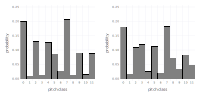

In [20]:
bayes_templates = normalize.(
    map(["major", "minor"]) do mode
        sum(root_position(pretemplates[p][modeindex(p, mode)]) for p in 2:3)
    end,
    1
)

set_default_plot_size(20cm, 10cm)
hstack(plot_template.(bayes_templates))

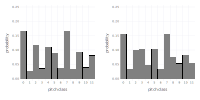

In [21]:
labeled_data = dropmissing(data, [:root, :mode], disallowmissing=true)

labeled_data.transposed = map(eachrow(labeled_data)) do piece
    pc_dist = piece[pcs] |> Vector
    circshift(pc_dist, -Int(piece.root))
end

mdata_templates = by(labeled_data, :mode, template = :transposed => mean, sort = true)[:template]

set_default_plot_size(20cm, 10cm)
hstack(plot_template.(mdata_templates))

In [22]:
all_templates = hcat(
    mdata_templates[1],
    mdata_templates[2],
    bayes_templates[1],
    bayes_templates[2],
    normalize([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88], 1),
    normalize([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17], 1),
    normalize([5.0, 2.0, 3.5, 2.0, 4.5, 4.0, 2.0, 4.5, 2.0, 3.5, 1.5, 4.0], 1),
    normalize([5.0, 2.0, 3.5, 4.5, 2.0, 4.0, 2.0, 4.5, 3.5, 2.0, 1.5, 4.0], 1),
    normalize([0.238, 0.006, 0.111, 0.006, 0.137, 0.094, 0.016, 0.214, 0.009, 0.080, 0.008, 0.081], 1),
    normalize([0.220, 0.006, 0.104, 0.123, 0.019, 0.103, 0.012, 0.214, 0.062, 0.022, 0.061, 0.052], 1)
)

templates_df = hcat(
    DataFrame(
        source = vcat(fill.(["metadata", "bayes", "krumhansl", "temperley", "albrecht"], 2)...),
        mode = vcat(fill(split("major minor"), 5)...)
    ),
    DataFrame(all_templates', Symbol.("pc", 0:11))
)

CSV.write("templates.csv", templates_df)

templates_df

,source,mode,pc0,pc1,pc2,pc3,pc4,pc5
,String,SubStri…,Float64,Float64,Float64,Float64,Float64,Float64
1,metadata,major,0.167282,0.0258889,0.11714,0.0356496,0.111231,0.0900446
2,metadata,minor,0.155646,0.0346276,0.0990316,0.104433,0.0484771,0.103971
3,bayes,major,0.199861,0.00895071,0.130082,0.0122289,0.126477,0.0854414
4,bayes,minor,0.179562,0.0168201,0.108441,0.119238,0.0255166,0.111965
5,krumhansl,major,0.15195,0.053362,0.0832735,0.055755,0.10481,0.0978703
6,krumhansl,minor,0.142215,0.0602112,0.0790834,0.120872,0.0584138,0.079308
7,temperley,major,0.12987,0.0519481,0.0909091,0.0519481,0.116883,0.103896
8,temperley,minor,0.12987,0.0519481,0.0909091,0.116883,0.0519481,0.103896
9,albrecht,major,0.238,0.006,0.111,0.006,0.137,0.094


# Renaissance templates

In [23]:
num_modes = 4

4

In [24]:
Random.seed!(42)

chain = bayesian_model(pcwds_by_period[1:1], num_modes, 1000)[11:end];

Gibbs sampling...100%|██████████████████████████████████| Time: 0:02:28


In [25]:
key_predictions = map(0:0) do period
    n = pieces_per_period[period]
    map(1:n) do piece
        first(maximum(counter(chain[i][period+1][piece] for i in eachindex(chain))))
    end
end

pretemplates = map(1:1) do period
    pretemplates = fill(zeros(12), num_modes)
    for ((root, mode), pcwd) in zip(key_predictions[period], rows(pcwds_by_period[period]))
        pretemplates[mode] += circshift(pcwd, root)
        # pretemplates[mode] += pcwd
    end
    # root_position.(pretemplates)
    pretemplates
end

templates = map(1:1) do period
    normalize.(pretemplates[period], 1) .|> root_position ## commented out FM
end

1-element Array{Array{Array{Float64,1},1},1}:
 [[0.16994470229825742, 0.0, 0.14447097088519018, 8.01182837206931e-6, 0.1299838969235377, 0.1494222842000022, 0.00018043873581358223, 0.17285730166197716, 0.003784390026102936, 0.06785729118313105, 0.161257320959488, 0.00023339129812777453], [0.18680472861804046, 0.0010907624424152937, 0.14463216957827532, 0.11107171432539412, 0.011685666946591265, 0.11763532749637035, 0.004444224697476318, 0.20048143542013552, 0.008003026529373533, 0.08057149111444825, 0.1251885954440126, 0.00839085738746697], [0.20150925050101265, 0.0024555592203791524, 0.1236156342216854, 0.13113805272318357, 0.016680333428650482, 0.10633571771617079, 0.0045559182936500365, 0.20636864300885727, 0.04064028049059973, 0.032409067340097485, 0.10621788194907085, 0.028073661106642812], [0.21249998058896888, 0.0020138387620853852, 0.1386207643204503, 0.0003729546360466308, 0.13335804159841427, 0.09075297455057274, 0.007147772183378063, 0.20842614349995583, 0.001017416280691638

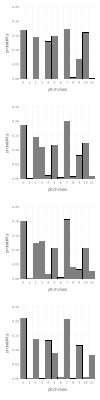

In [26]:
function plot_template(template)
    plot(x = 0:11, y = template, 
        Geom.bar, 
        Scale.x_discrete,
        Coord.cartesian(ymin=0, ymax=0.25),
        Theme(bar_highlight=color(colorant"black"), default_color=color(colorant"grey")),
        Guide.xlabel("pitch class"),
        Guide.ylabel("probability") )
end

set_default_plot_size(10cm, 40cm)

# vstack([plot_template(root_position(t)) for t in templates[1]])
vstack([plot_template(t) for t in templates[1]])

In [27]:
template_roots = [find_root.(pretemplates[p]) for p in 1:1]

1-element Array{Array{Int64,1},1}:
 [8, 6, 7, 5]

In [28]:
calibrated_key_predictions = map(1:1) do period
    map(key_predictions[period]) do (root, mode)
        (root = mod(template_roots[period][mode] - root, 12), mode = mode)
    end
end

@> DataFrame(calibrated_key_predictions[1]) |> 
    groupby(_, [:mode, :root]) |>
    combine(_, :root => length) |>
    rename(_, :root_length => :root_count) |>
    sort(_, [:mode, :root_count]) |> 
    showall

31×3 DataFrame
│ Row │ mode  │ root  │ root_count │
│     │ Int64 │ Int64 │ Int64      │
├─────┼───────┼───────┼────────────┤
│ 1   │ 1     │ 2     │ 1          │
│ 2   │ 1     │ 4     │ 1          │
│ 3   │ 1     │ 0     │ 2          │
│ 4   │ 1     │ 7     │ 247        │
│ 5   │ 2     │ 11    │ 1          │
│ 6   │ 2     │ 5     │ 1          │
│ 7   │ 2     │ 10    │ 2          │
│ 8   │ 2     │ 9     │ 3          │
│ 9   │ 2     │ 0     │ 7          │
│ 10  │ 2     │ 2     │ 74         │
│ 11  │ 2     │ 7     │ 157        │
│ 12  │ 3     │ 1     │ 1          │
│ 13  │ 3     │ 6     │ 1          │
│ 14  │ 3     │ 10    │ 3          │
│ 15  │ 3     │ 11    │ 3          │
│ 16  │ 3     │ 5     │ 4          │
│ 17  │ 3     │ 4     │ 10         │
│ 18  │ 3     │ 0     │ 23         │
│ 19  │ 3     │ 9     │ 68         │
│ 20  │ 3     │ 7     │ 73         │
│ 21  │ 3     │ 2     │ 75         │
│ 22  │ 4     │ 11    │ 1          │
│ 23  │ 4     │ 9     │ 3          │
│ 24  │ 4     │ 2     │

In [29]:
second((x,y)) = y

prediction_df = DataFrame(
    period = vcat([fill(p, pieces_per_period[p]) for p in 0:0]...),
    root   = first.(vcat(calibrated_key_predictions...)),
    mode   = second.(vcat(calibrated_key_predictions...)) )
    #root   = first.(vcat(key_predictions...)),
    #mode   = second.(vcat(key_predictions...)) )

first(prediction_df, 6)

,period,root,mode
,Int64,Int64,Int64
1,0,7,2
2,0,7,2
3,0,7,2
4,0,7,2
5,0,7,2
6,0,7,2


In [30]:
CSV.write("renaissance_predictions_$(num_modes)_modes.csv", prediction_df)

"renaissance_predictions_4_modes.csv"